<a href="https://colab.research.google.com/github/wkdth04/hanghae99AI3th/blob/%EA%B3%BC%EC%A0%9C/W4_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C_%EC%8B%A4%EC%8A%B5_%EC%9E%A5%EC%86%8C%EC%97%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [4주차] 심화과제 - 수능 국어 문제 GPT-4로 풀어보기

이번 과제에서는 2023년도 수능 국어 문제를 GPT-4로 풀어볼 것입니다. 아래 요구사항들을 지켜주시면 됩니다.

- 수능 국어 문제를 준비합니다. 다음 github의 `data > 2023_11_KICE.json` data를 colab으로 불러오시면 됩니다:
    
    [GitHub - NomaDamas/KICE_slayer_AI_Korean: 수능 국어 1등급에 도전하는 AI](https://github.com/NomaDamas/KICE_slayer_AI_Korean)
    
- 하나의 문제에 대해서 GPT-4의 예측 결과를 내놓는 함수를 `def prediction(problem)`이라는 signature로 만드셔야 합니다. `problem`은 json 형태의 문제입니다. 내부는 logit 계산을 통해 구현하거나 순수하게 text 생성으로 해결하셔도 좋습니다. ***단, 2023년도 수능 국어의 정답을 활용하시면 안됩니다.***
- `def prediction` 함수를 모든 수능 국어 문제들에 대해서 돌린 후, 실제 정답과 비교하여 GPT-4의 점수를 계산하는 코드를 구현하시면 됩니다. ***단, 점수 계산은 모두 코드를 통해서만 진행되어야 합니다.*** 사람이 직접 GPT-4의 출력 결과를 보고 대조하는 형식으로 되면 안됩니다.
-  채점 결과 80점을 넘기면 통과입니다.

GPT API 사용 및 GPT-4o를 사용해야 한다는 것 이외에는 제약사항이 없습니다.

### json data 로드

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 2023_11_KICE.json to 2023_11_KICE (1).json


In [ ]:
import pandas as pd

json_data = pd.read_json('2023_11_KICE.json')
print(len(json_data))
json_data.head()

11


,id,paragraph,type,problems
0,2023_11_KICE_1-3,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다. 독서의 즐거움에는 여러 ...,0,"[{'question': '윗글의 내용과 일치하지 않는 것은?', 'choices'..."
1,2023_11_KICE_4-9,(가)[A](중국에서 비롯된 유서(類書)는 고금의 서적에서 자료를 수집하고 항목별로...,0,"[{'question': '(가)와 (나)에 대한 설명으로 가장 적절한 것은?', ..."
2,2023_11_KICE_10-13,법령의 조문은 대개 ‘A에 해당하면 B를 해야 한다.’처럼 요건과효과로 구성된 조건...,0,"[{'question': '윗글의 내용과 일치하지 않는 것은?', 'choices'..."
3,2023_11_KICE_14-17,하루에 필요한 에너지의 양은 하루 동안의 총 열량 소모량인 대사량으로 구한다. 그중...,0,"[{'question': '윗글의 내용과 일치하지 않는 것은?', 'choices'..."
4,2023_11_KICE_18-21,혼례를 마친 후 최척이 아내와 함께 장모를 모시고 집으로 돌아오매 하인들이 기뻐했다...,1,"[{'question': '윗글에 대한 설명으로 가장 적절한 것은?', 'choic..."


In [ ]:
json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         11 non-null     object
 1   paragraph  11 non-null     object
 2   type       11 non-null     int64 
 3   problems   11 non-null     object
dtypes: int64(1), object(3)
memory usage: 484.0+ bytes


### 데이터 전처리




In [ ]:
class Paragraph:
    def __init__(self, data):
        self.id        = data['id']
        self.paragraph = data['paragraph']
        self.type      = data['type']
        self.problems  = []

        self._parse_problems(data['problems'])

    def _parse_problems(self, data_list):
        for data in data_list:
            problem = Problem(data, self.paragraph)
            self.problems.append(problem)

    def __str__(self):
        lines = f'Paragraph({self.id}): type({self.type})'
        for problem in self.problems:
            lines += f'\n\t- {problem.number}) {problem}'
        return lines

In [ ]:
class Problem:
    _number = 0

    def __init__(self, data, paragraph=None):
        if 'number' in data:
            self.number = data['number']
        else:
            Problem._number += 1
            self.number = Problem._number

        self.paragraph = data['paragraph'] if 'paragraph' in data else paragraph
        self.question_plus = data['question_plus'] if 'question_plus' in data else ''
        self.question = data['question']
        self.choices = data['choices']
        self.answer = data['answer']
        self.score = data['score']

    def predict(self, label):
        match = re.search(r"[1-5]", label)
        if match:
            predicted = int(match.group())
            return self.score if predicted == int(self.answer) else 0
        else:
            print(f"⚠️ 예측값에서 숫자를 찾을 수 없습니다: {label}")
            return 0

    def to_json(self):
        problem_dict = {
            "number": self.number,
            "paragraph": self.paragraph,
            "question_plus": self.question_plus,
            "question": self.question,
            "choices": self.choices,
            "answer": self.answer,
            "score": self.score
        }

        return json.dumps(problem_dict, ensure_ascii=False, indent=4)

    def __str__(self):
        return self.question


In [ ]:
problem_list = []

for i in range(len(json_data)):
    paragraph_data = json_data.iloc[i]
    paragraph = Paragraph(paragraph_data)
    for problem in paragraph.problems:
        problem_list.append(problem)
    print(paragraph)

Paragraph(2023_11_KICE_1-3): type(0)
	- 1) 윗글의 내용과 일치하지 않는 것은?
	- 2) 다음은 학생이 독서 후 작성한 글의 일부이다. [A]를 바탕으로 ⓐ～ⓔ를 이해한 내용으로 가장 적절한 것은?
	- 3) 윗글을 읽고 ㉠에 대해 보인 반응으로 적절하지 않은 것은?
Paragraph(2023_11_KICE_4-9): type(0)
	- 4) (가)와 (나)에 대한 설명으로 가장 적절한 것은?
	- 5) [A]에 대한 이해로 적절하지 않은 것은?
	- 6) ㉮에 대한 이해를 바탕으로 ㉠, ㉡에 대해 파악한 내용으로 적절하지 않은 것은?
	- 7) ㉯를 반박하기 위한 ‘이수광’의 말로 가장 적절한 것은?
	- 8) (가), (나)를 읽은 학생이 <보기>의 임원경제지에 대해 보인 반응으로 적절하지 않은 것은?
	- 9) 문맥상 ⓐ～ⓔ와 바꾸어 쓰기에 적절하지 않은 것은?
Paragraph(2023_11_KICE_10-13): type(0)
	- 10) 윗글의 내용과 일치하지 않는 것은?
	- 11) ㉠에 대한 이해로 가장 적절한 것은?
	- 12) 윗글을 바탕으로 <보기>를 이해한 내용으로 가장 적절한 것은? [3점]
	- 13) 문맥상 ⓐ～ⓔ의 의미와 가장 가까운 것은?
Paragraph(2023_11_KICE_14-17): type(0)
	- 14) 윗글의 내용과 일치하지 않는 것은?
	- 15) 윗글을 읽고 추론한 내용으로 적절하지 않은 것은?
	- 16) ㉠, ㉡에 대한 이해로 가장 적절한 것은?
	- 17) 윗글을 바탕으로 <보기>를 탐구한 내용으로 가장 적절한 것은?
Paragraph(2023_11_KICE_18-21): type(1)
	- 18) 윗글에 대한 설명으로 가장 적절한 것은?
	- 19) 윗글의 인물에 대한 이해로 적절하지 않은 것은?
	- 20) ㉠～㉤에 대한 이해로 가장 적절한 것은?
	- 21) <보기>를 바탕으로 윗글을 감상한 내용으로 적절하지 않은것은?
Paragraph(2023_11_KICE_22

In [ ]:
print(problem_list[0].to_json())

{
    "number": 1,
    "paragraph": "사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다. 독서의 즐거움에는 여러 가지가 있겠지만 그 중심에는 ‘소통의 즐거움’이 있다.독자는 독서를 통해 책과 소통하는 즐거움을 경험한다. 독서는필자와 간접적으로 대화하는 소통 행위이다. 독자는 자신이 속한사회나 시대의 영향 아래 필자가 속해 있거나 드러내고자 하는 사회나 시대를 경험한다. 직접 경험하지 못했던 다양한 삶을 필자를 매개로 만나고 이해하면서 독자는 더 넓은 시야로 세계를바라볼 수 있다. 이때 같은 책을 읽은 독자라도 독자의 배경지식이나 관점 등의 독자 요인, 읽기 환경이나 과제 등의 상황 요인이 다르므로, 필자가 보여 주는 세계를 그대로 수용하지 않고 저마다 소통 과정에서 다른 의미를 구성할 수 있다.[A] (이러한 소통은 독자가 책의 내용에 대해 질문하고 답을 찾아내는 과정에서 가능해진다. 독자는 책에서 답을 찾는 질문, 독자 자신에게서 답을 찾는 질문 등을 제기할 수 있다. 전자의 경우 책에 명시된 내용에서 답을 발견할 수 있고, 책의 내용들을 관계 지으며 답에 해당하는 내용을 스스로 구성할 수도 있다. 또한 후자의 경우 책에는 없는 독자의 경험에서 답을 찾을 수 있다. 이런 질문들을 풍부히 생성하고 주체적으로 답을 찾을 때 소통의 즐거움은 더 커진다.)한편 독자는 ㉠ (다른 독자와 소통하는 즐거움을 경험할 수도 있다.) 책과의 소통을 통해 개인적으로 형성한 의미를 독서 모임이나 독서 동아리 등에서 다른 독자들과 나누는 일이 이에 해당한다. 비슷한 해석에 서로 공감하며 기존 인식을 강화하거나 관점의 차이를 확인하고 기존 인식을 조정하는 과정에서, 독자는자신의 인식을 심화 확장할 수 있다. 최근 소통 공간이 온라인으로 확대되면서 독서를 통해 다른 독자들과 소통하며 즐거움을누리는 양상이 더 다양해지고 있다. 자신의 독서 경험을 담은 글이나 동영상을 생산 공유함으로써, 책을 읽지 않은 타인이 책과 소통하도록 돕는 것도 책을 통한 소통

### OpenAI ChatClient
오픈AI 키발급 사이트
https://platform.openai.com/settings/organization/api-keys

In [ ]:
### Colab에서 키를 안전하게 직접 입력 받기
import getpass

api_key = getpass.getpass('Enter your OpenAI API key: ')

Enter your OpenAI API key: ··········


In [ ]:
from openai import OpenAI
from google.colab import userdata

class OpenAIChatClient:
    def __init__(self, api_key):
        self.client = OpenAI(api_key=api_key)
        self.model = "gpt-4o"
        self.n = 1
        self.max_tokens = 4096
        self.temperature = 0.5
        self.frequency_penalty = 0.0

    def get_response(self, messages):

        if isinstance(messages, str):
            temp = [
                         {
                            "role": "user",
                            "content": messages
                        }
                    ]
            messages = temp

        response = self.client.chat.completions.create(
            model=self.model,
            n=self.n,
            max_tokens=self.max_tokens,
            temperature=self.temperature,
            frequency_penalty=self.frequency_penalty,
            messages=messages
        )
        return response.choices[0].message.content

In [ ]:
chatgpt_client = OpenAIChatClient(api_key)
print(chatgpt_client.get_response('안녕 난 장소연이라고 해. 넌 누구니?'))

안녕하세요, 장소연님! 저는 AI 어시스턴트입니다. 궁금한 점이나 도움이 필요하시면 언제든지 말씀해 주세요.


### 프롬프트 작성

In [ ]:
from langchain.prompts import PromptTemplate

class PromptTemplate:
    def __init__(self, name, prompt):
        self.name = name
        self.prompt = prompt

    def compile(self, paragraph, question, question_plus, choice_list):
            return self.prompt.format(
                paragraph=paragraph,
                question=question,
                question_plus=question_plus,
                choices_1=choice_list[0],
                choices_2=choice_list[1],
                choices_3=choice_list[2],
                choices_4=choice_list[3],
                choices_5=choice_list[4])
'''
    def compile(self, paragraph, question, question_plus, choice):
        return self.prompt.format(
            paragraph=paragraph,
            question=question,
            question_plus=question_plus,
            choice=choice
        )'''

'\n    def compile(self, paragraph, question, question_plus, choice):\n        return self.prompt.format(\n            paragraph=paragraph,\n            question=question,\n            question_plus=question_plus,\n            choice=choice\n        )'

방식1. COT

In [ ]:
prompt_templates = []

'''
TODO: 자유자재로 최대한 많은 종류의 프롬프팅 기법들을 활용하여 점수를 비교해보자!!!!
'''

# COT
prompt_templates.append(PromptTemplate('zero_shot_cot', """ 국어 시험 문제를 푸는 똑똑한 학생으로서 다음 문제의 답을 구하세요.
    지문을 읽고, 질문에 대한 답을 1부터 5까지의 선택지 중에 한 개만 골라서 대답해야 합니다.

    지문 :
    {paragraph}

    질문 :
    {question}

    선택지 :
    1번 - {choices_1}
    2번 - {choices_2}
    3번 - {choices_3}
    4번 - {choices_4}
    5번 - {choices_5}

    1번, 2번, 3번, 4번, 5번 중에 하나를 정답으로 고르세요.
    단계별로 생각하며 정답을 고르세요.

"""))

방식2. 감정에 호소


In [ ]:
# 감정호소

prompt_templates.append(PromptTemplate('emotional', """ 국어 시험 문제의 답을 구하세요.
    지문을 읽고, 질문에 대한 답을 1부터 5까지의 선택지 중에 한 개만 골라서 대답해야 합니다.

    지문 :
    {paragraph}

    질문 :
    {question}

    선택지 :
    1번 - {choices_1}
    2번 - {choices_2}
    3번 - {choices_3}
    4번 - {choices_4}
    5번 - {choices_5}

    1번, 2번, 3번, 4번, 5번 중에 하나를 정답으로 고르세요.
    이 문제를 틀리면 전 너무 슬플 것 같습니다. 저를 위해 꼭 정확한 정답을 찾아주세요.

"""))

방식3. one-shot 프롬프트


In [ ]:
# 원-샷 프롬프트

prompt_templates.append(PromptTemplate('one_shot',     """
    다음은 전년도 수능 국어 시험의 문제와 풀이입니다.

    <문제 1>
    지문 :
    다음 글을 읽고 물음에 답하시오. 일일은 승상이 술에 취하시어 ⓐ(책상)에 의지하여 잠깐 졸더니 문득 봄바람에 이끌려 한 곳에 다다르니 이곳은 승상이 평소에 고기도 낚으며 풍경을 구경하던 조대(釣臺)*라. 그 위에 상서로운 기운이 어렸거늘 나아가 보니 청룡이 ⓑ(조대)에 누웠다가 승상을 보고 고개를 들어 소리를 지르고 반공에 솟거늘, 깨달으니 일장춘몽이라. [A](심신이 황홀하여 죽장을 짚고 월령산 ⓒ(조대)로 나아가니 나무 베는 아이가 나무를 베어 시냇가에 놓고 버들 그늘을 의지하여 잠이 깊이 들었거늘, 보니 의상이 남루하고 머리털이 흩어져 귀밑을 덮었으며 검은 때 줄줄이 흘러 두 뺨에 가득하니 그 추레함을 측량치 못하나 그 중에도 은은한 기품이 때 속에 비치거늘 승상이 깨우지 않으시고, 옷에 무수한 이를 잡아 죽이며 잠 깨기를 기다리더니, 그 아이가 돌아누우며 탄식 왈,  “㉠(형산백옥이 돌 속에 섞였으니 누가 보배인 줄 알아보랴. 여상의 자취 조대에 있건마는 그를 알아본 문왕의 그림자 없고 와룡은 남양에 누웠으되 삼고초려한 유황숙의 자취는 없으니 어느 날에 날 알아줄 이 있으리오.)”하니 그 소리 웅장하여 산천이 울리는지라.) 탈속한 기운이 소리에 나타나니, 승상이 생각하되, ‘영웅을 구하더니 이제야 만났도다.’ 하시고, 깨우며 물어 왈,“봄날이 심히 곤한들 무슨 잠을 이리 오래 자느냐? 일어앉으면 물을 말이 있노라.”“어떤 사람이관데 남의 단잠을 깨워 무슨 말을 묻고자 하는가? 나는 배고파 심란하여 말하기 싫도다.”아이 머리를 비비며 군말하고 도로 잠이 들거늘, 승상이 왈,“네 비록 잠이 달지만 어른을 공경치 아니하느냐. 눈을 들어 날 보면 자연 알리라.”그 아이 눈을 뜨고 이윽히 보다가 일어앉으며 고개를 숙이고 잠잠하거늘, 승상이 자세히 보니 두 눈썹 사이에 천지조화를 갈무리하고 가슴속에 만고흥망을 품었으니 진실로 영웅이라. 승상의 ㉡(명감(明鑑)*)이 아니면 그 누가 알리오.[중략 부분의 줄거리] 승상은 아이(소대성)를 자기 집에 묵게 하고 딸과 부부의 연을 맺도록 하지만, 승상이 죽자 그 아들들이 대성을 제거하려고 한다. 이에 대성은 영보산으로 옮겨 공부하다가 호왕이 난을 일으킨 소식에 산을 나가게 된다.한 동자 마중 나와 물어 왈,“상공이 해동 소상공 아니십니까?”“동자, 어찌 나를 아는가?”소생이 놀라 묻자, 동자 답 왈, “우리 노야의 분부를 받들어 기다린 지 오랩니다.”“노야라 하시는 이는 뉘신고?”“아이 어찌 어른의 존호를 알리이까? 들어가 보시면 자연 알리이다.” [B](생이 동자를 따라 들어가니 청산에 불이 명랑하고 한 노인이 자줏빛 도포를 입고 금관을 쓰고 책상을 의지하여 앉았거늘 생이 보니 학발 노인은 청주 이 승상일러라. 생이 생각하되, ‘승상이 별세하신 지 오래이거늘 어찌 ⓓ(이곳)에 계신가?’ 하는데, 승상이 반겨 손을 잡고 왈,  “내 그대를 잊지 못하여 줄 것이 있어 그대를 청하였나니 기쁘고도 슬프도다.”)하고 동자를 명하여 저녁을 재촉하며 왈,“내 자식이 무도하여 그대를 알아보지 못하고 망령된 의사를 두었으니 어찌 부끄럽지 아니하리오. 하나 그대는 대인군자로 허물치 아니할 줄 알았거니와 모두 하늘의 뜻이라. 오래지 아니하여 공명을 이루고 용문에 오르면 딸과의 신의를 잊지 말라.”하고 갑주 한 벌을 내어 주며 왈,“이 갑주는 보통 물건이 아니라 입으면 내게 유익하고 남에게 해로우며 창과 검이 뚫지 못하니 천하의 얻기 어려운 보배라. 그대를 잊지 못하여 정을 표하나니 전장에 나가 대공을 이루라.”생이 자세히 보니 쇠도 아니요, 편갑도 아니로되 용의 비늘 같이 광채 찬란하며 백화홍금포로 안을 대었으니 사람의 정신이 황홀한지라. 생이 매우 기뻐 물어 왈,“이 옷이 범상치 아니하니 근본을 알고자 하나이다.”“이는 천공의 조화요, 귀신의 공역이라. 이름은 ‘보신갑’이니 그 조화를 헤아리지 못하리라. 다시 알아 무엇 하리오?”승상이 답하시고, 차를 내어 서너 잔 마신 후에 승상 왈,“이제 칠성검과 보신갑을 얻었으니 만 리 청총마를 얻으면 그대 재주를 펼칠 것이나, 그렇지 아니하면 당당한 기운을 걷잡지 못하리라. 하나 적을 가벼이 여기지 말라. 지금 적장은 천상 나타의 제자 익성이니 북방 호국 왕이 되어 중원을 침노하니 지혜와 용맹이 범인과 다른지라. 삼가 조심하라.”“만 리 청총마를 얻을 길이 없으니 어찌 공명을 이루리까?”생이 묻자, 승상이 답 왈,“동해 용왕이 그대를 위하여 이리 왔으니 내일 오시에 얻을 것이니 급히 공을 이루라. 지금 싸움이 오래되었으나 중국은 익성을 대적할 자 없으며 황제 지금 위태한지라. 머물지 말고 바삐 가라. 할 말이 끝없으나 밤이 깊었으니 자고 가라.”하시고 책상을 의지하여 누우시니 생도 잠깐 졸더니, 홀연 찬바람, 기러기 소리에 깨달으니 승상은 간데없고 누웠던 자리에 갑옷과 투구 놓였거늘 좌우를 둘러보니 ⓔ(소나무) 밑이라.- 작자 미상, ｢소대성전｣ -* 조대 : 낚시터.* 명감 : 사람을 알아보는 뛰어난 능력.

    질문 :
     윗글의 ‘승상’에 대한 감상으로 가장 적절한 것은?

    선택지 :
    1번 - 곤히 잠든 ‘아이’를 깨우지 않고 이를 잡아 주며 기다리는 모습에서 따뜻한 인정을 느낄 수 있군.
    2번 - 나이 어린 ‘소생’에게 자신이 범한 과오를 시인하고 부끄러워하는 모습에서 자신을 비우고 낮추는 겸허함을 볼 수 있군.
    3번 - ‘소생’에게 ‘딸과의 신의’를 잊지 않아야 공명을 이룰 수 있다고 당부하는 모습에서 신의를 중시하는 가치관을 볼 수 있군.
    4번 - ‘청총마’를 이미 얻고 ‘동해 용왕’의 도움까지 얻은 ‘소생’에게 적을 가벼이 여기지 말라고 하는 모습에서 신중한 자세를 볼 수 있군.
    5번 - 살아서는 ‘소생’을 도왔지만 죽은 몸으로 ‘소생’을 도울 수 없어 안타까워하는 모습에서 남을 도우려는 한결같은 성품을 느낄 수 있군.

    정답해설 :
    ‘나무 베는 아이’의 ‘추레함’을 보고도 이를 회피하거나 동정하지 않고 그 옆에서 아이의 옷에 있는 이를 잡아주며 아이가 잠을 깨기를 기다리는 승상의 모습을 통해 그의 따뜻한 인품을 짐작할 수 있다.

    정답 : 1번

    """))

### 이제 문제를 풀어보자

In [ ]:
def predict(json_text, prompt_template):
    problem = Problem(json.loads(json_text))

    prompt = prompt_template.compile(
        paragraph=problem.paragraph,
        question=problem.question,
        question_plus=problem.question_plus,
        choice_list=problem.choices  # ✅ 리스트로 넘김
    )

    answer = chatgpt_client.get_response(prompt)
    score = problem.predict(answer)
    print(f'{problem.number}번 문제: (정답:{problem.answer}), (예측:{answer}) -> [점수:{score}점]' )
    return score


'''def predict(json_text, prompt_template):
    problem = Problem(json.loads(json_text))

    choice_text = ''
    for idx, text in enumerate(problem.choices):
        choice_text += f'({idx+1}): {text}\n'

    prompt = prompt_template.compile(
        paragraph=problem.paragraph,
        question=problem.question,
        question_plus=problem.question_plus,
        choice=choice_text
    )

    #print(prompt_template.prompt)

    answer = chatgpt_client.get_response(prompt)
    score = problem.predict(answer)
    print(f'{problem.number}번 문제: (정답:{problem.answer}), (예측:{answer}) -> [점수:{score}점]' )
    return score'''

"def predict(json_text, prompt_template):\n    problem = Problem(json.loads(json_text))\n\n    choice_text = ''\n    for idx, text in enumerate(problem.choices):\n        choice_text += f'({idx+1}): {text}\n'\n\n    prompt = prompt_template.compile(\n        paragraph=problem.paragraph,\n        question=problem.question,\n        question_plus=problem.question_plus,\n        choice=choice_text\n    )\n\n    #print(prompt_template.prompt)\n\n    answer = chatgpt_client.get_response(prompt)\n    score = problem.predict(answer)\n    print(f'{problem.number}번 문제: (정답:{problem.answer}), (예측:{answer}) -> [점수:{score}점]' )\n    return score"

### 프롬프트별 예측 및 비교

In [ ]:
type(json_data)

pandas.core.frame.DataFrame

In [ ]:
# 기존 점수 데이터 로드
score_df = json_data.copy()

In [ ]:
score_df = pd.DataFrame(columns=['name', 'score'])

In [ ]:
for prompt_template in prompt_templates:
    total_score = 0

    if prompt_template.name in score_df['name'].values:
        # 이미 존재하면 점수 출력
        total_score = score_df.loc[score_df['name'] == prompt_template.name, 'score'].values[0]
    else:
        print(f"채점 시작({prompt_template.name})!")

        for problem in problem_list:
            score = predict(problem.to_json(), prompt_template)
            total_score += score

        # 존재하지 않으면 새로운 데이터프레임 추가
        new_row = {'name': prompt_template.name, 'score': total_score}
        score_df = pd.concat([score_df, pd.DataFrame([new_row])], ignore_index=True)
        score_df.to_csv('score.csv', index=False)  # 🔧 파일명 명시!

    print(f"{prompt_template.name} 프롬프트 점수: {total_score}")


채점 시작(zero_shot_cot)!
1번 문제: (정답:4), (예측:주어진 지문을 바탕으로 각 선택지를 검토해 보겠습니다.

1번 - "같은 책을 읽은 독자라도 서로 다른 의미를 구성할 수 있다."  
   - 지문에서 "같은 책을 읽은 독자라도 독자의 배경지식이나 관점 등의 독자 요인, 읽기 환경이나 과제 등의 상황 요인이 다르므로, 필자가 보여 주는 세계를 그대로 수용하지 않고 저마다 소통 과정에서 다른 의미를 구성할 수 있다."라고 명시되어 있어 지문과 일치합니다.

2번 - "다른 독자와의 소통은 독자가 인식의 폭을 확장하도록 돕는다"  
   - 지문에서 "비슷한 해석에 서로 공감하며 기존 인식을 강화하거나 관점의 차이를 확인하고 기존 인식을 조정하는 과정에서, 독자는 자신의 인식을 심화 확장할 수 있다."라고 설명되어 있어 지문과 일치합니다.

3번 - "독자는 직접 경험해 보지 못했던 다양한 삶을 책의 필자를 매개로 접할 수 있다."  
   - 지문에서 "직접 경험하지 못했던 다양한 삶을 필자를 매개로 만나고 이해하면서 독자는 더 넓은 시야로 세계를 바라볼 수 있다."라고 명시되어 있어 지문과 일치합니다.

4번 - "독자의 배경지식, 관점, 읽기 환경, 과제는 독자의 의미 구성에 영향을 주는 독자 요인이다."  
   - 지문에서 "독자의 배경지식이나 관점 등의 독자 요인, 읽기 환경이나 과제 등의 상황 요인"이라고 설명되어 있습니다. 즉, 읽기 환경과 과제는 독자 요인이 아니라 상황 요인으로 분류됩니다. 따라서 이 선택지는 지문과 일치하지 않습니다.

5번 - "독자는 책을 읽을 때 자신이 속한 사회나 시대의 영향을 받으며 필자와 간접적으로 대화한다"  
   - 지문에서 "독서는 필자와 간접적으로 대화하는 소통 행위이다. 독자는 자신이 속한 사회나 시대의 영향 아래..."라고 설명되어 있어 지문과 일치합니다.

따라서, 지문과 일치하지 않는 선택지는 4번입니다. 정답은 4번입니다.) -> [점수:0점]
2번 문제: (정답:5), (예측

### 프롬프트 별 점수 시각화(Bar chart)

<ipython-input-90-fa3535216f88>:20: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-90-fa3535216f88>:20: UserWarning: Glyph 47212 (\N{HANGUL SYLLABLE ROM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-90-fa3535216f88>:20: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-90-fa3535216f88>:20: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-90-fa3535216f88>:20: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-90-fa3535216f88>:20: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-90-fa3535216f88>:20: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ip

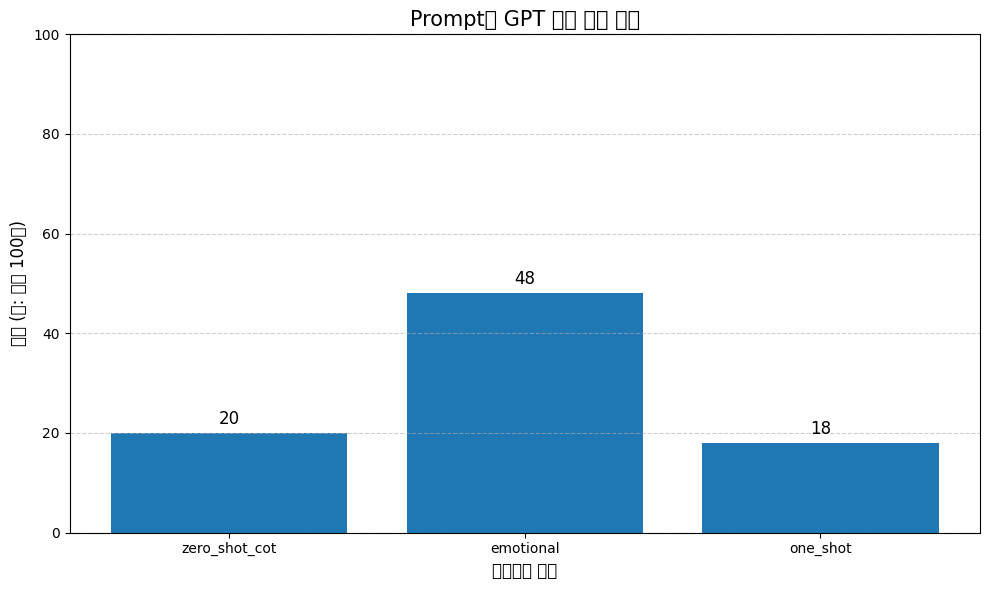

In [ ]:
import matplotlib.pyplot as plt

# CSV로 저장된 점수 불러오기 (이미 score_df가 있다면 생략 가능)
score_df = pd.read_csv('score.csv')  # 혹은 이미 메모리에 있으면 이 줄 생략 가능

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(score_df['name'], score_df['score'])

# 점수 텍스트 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.0f}', ha='center', va='bottom', fontsize=12)

plt.title('Prompt별 GPT 수능 국어 점수', fontsize=15)
plt.xlabel('프롬프트 종류', fontsize=12)
plt.ylabel('총점 (예: 최대 100점)', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 1. 문제별 정답/오답 시각화 (Scatter Plot)


1번 문제: (정답:4), (예측:주어진 지문을 분석하고 질문에 대한 답을 찾기 위해 각 선택지를 검토해 보겠습니다.

1. **1번 선택지**: "같은 책을 읽은 독자라도 서로 다른 의미를 구성할 수 있다."  
   - 지문에서 "같은 책을 읽은 독자라도 독자의 배경지식이나 관점 등의 독자 요인, 읽기 환경이나 과제 등의 상황 요인이 다르므로, 필자가 보여 주는 세계를 그대로 수용하지 않고 저마다 소통 과정에서 다른 의미를 구성할 수 있다."라고 언급하고 있습니다. 따라서 1번은 지문과 일치합니다.

2. **2번 선택지**: "다른 독자와의 소통은 독자가 인식의 폭을 확장하도록 돕는다."  
   - 지문에서 "비슷한 해석에 서로 공감하며 기존 인식을 강화하거나 관점의 차이를 확인하고 기존 인식을 조정하는 과정에서, 독자는 자신의 인식을 심화 확장할 수 있다."라고 언급하고 있습니다. 따라서 2번도 지문과 일치합니다.

3. **3번 선택지**: "독자는 직접 경험해 보지 못했던 다양한 삶을 책의 필자를 매개로 접할 수 있다."  
   - 지문에서 "직접 경험하지 못했던 다양한 삶을 필자를 매개로 만나고 이해하면서 독자는 더 넓은 시야로 세계를 바라볼 수 있다."라고 언급하고 있습니다. 따라서 3번도 지문과 일치합니다.

4. **4번 선택지**: "독자의 배경지식, 관점, 읽기 환경, 과제는 독자의 의미 구성에 영향을 주는 독자 요인이다."  
   - 지문에서는 "독자의 배경지식이나 관점 등의 독자 요인, 읽기 환경이나 과제 등의 상황 요인이 다르므로"라고 언급하고 있습니다. 여기서 읽기 환경과 과제는 독자 요인이 아니라 상황 요인으로 분류됩니다. 따라서 4번은 지문과 일치하지 않습니다.

5. **5번 선택지**: "독자는 책을 읽을 때 자신이 속한 사회나 시대의 영향을 받으며 필자와 간접적으로 대화한다."  
   - 지문에서 "독서는 필자와 간접적으로 대화하는 소통 행위이다. 독자는 자신이 속한 사회나 시대의 영향 아래 필자가 속해 있거나 드러

<ipython-input-91-58a9a2e8dfed>:21: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-91-58a9a2e8dfed>:21: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-91-58a9a2e8dfed>:21: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-91-58a9a2e8dfed>:21: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-91-58a9a2e8dfed>:21: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-91-58a9a2e8dfed>:21: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-91-58a9a2e8dfed>:21: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipytho

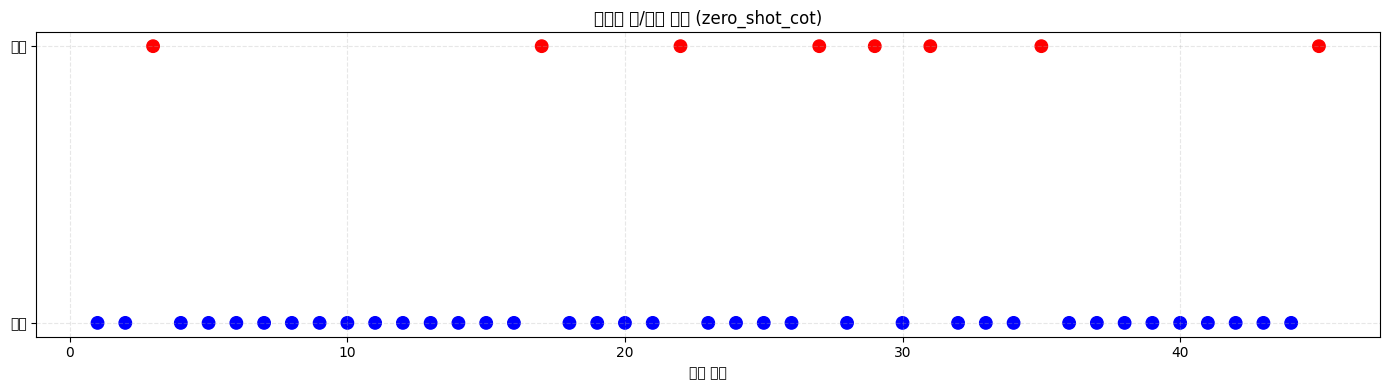

In [ ]:
import matplotlib.pyplot as plt

# 문제별 결과 저장용 리스트
problem_ids = [problem.number for problem in problem_list]
results = []

# 선택한 프롬프트 하나에 대해서 예측 및 정오 표시
template = prompt_templates[0]  # 예: zero_shot_cot

for problem in problem_list:
    score = predict(problem.to_json(), template)
    results.append(1 if score > 0 else 0)

# 시각화
plt.figure(figsize=(14, 4))
plt.scatter(problem_ids, results, c=results, cmap='bwr', s=80)
plt.yticks([0, 1], ['오답', '정답'])
plt.title(f'문제별 정/오답 분포 ({template.name})')
plt.xlabel('문제 번호')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### 2. 시간 흐름에 따른 점수 변화 로그 (Line Plot)


1번 문제: (정답:4), (예측:주어진 지문은 독서의 즐거움과 소통의 역할에 대해 설명하고 있습니다. 질문은 지문의 내용과 일치하지 않는 선택지를 고르는 것입니다. 각 선택지를 지문의 내용과 비교하여 분석해 보겠습니다.

1번 - "같은 책을 읽은 독자라도 서로 다른 의미를 구성할 수 있다."  
   - 지문에서 "같은 책을 읽은 독자라도 독자의 배경지식이나 관점 등의 독자 요인, 읽기 환경이나 과제 등의 상황 요인이 다르므로, 필자가 보여 주는 세계를 그대로 수용하지 않고 저마다 소통 과정에서 다른 의미를 구성할 수 있다."라고 설명합니다. 따라서 1번은 지문과 일치합니다.

2번 - "다른 독자와의 소통은 독자가 인식의 폭을 확장하도록 돕는다."  
   - 지문에서 "비슷한 해석에 서로 공감하며 기존 인식을 강화하거나 관점의 차이를 확인하고 기존 인식을 조정하는 과정에서, 독자는 자신의 인식을 심화 확장할 수 있다."라고 설명합니다. 따라서 2번은 지문과 일치합니다.

3번 - "독자는 직접 경험해 보지 못했던 다양한 삶을 책의 필자를 매개로 접할 수 있다."  
   - 지문에서 "직접 경험하지 못했던 다양한 삶을 필자를 매개로 만나고 이해하면서 독자는 더 넓은 시야로 세계를 바라볼 수 있다."라고 설명합니다. 따라서 3번은 지문과 일치합니다.

4번 - "독자의 배경지식, 관점, 읽기 환경, 과제는 독자의 의미 구성에 영향을 주는 독자 요인이다."  
   - 지문에서 "독자의 배경지식이나 관점 등의 독자 요인, 읽기 환경이나 과제 등의 상황 요인"이라고 설명합니다. 읽기 환경과 과제는 독자 요인이 아니라 상황 요인으로 분류됩니다. 따라서 4번은 지문과 일치하지 않습니다.

5번 - "독자는 책을 읽을 때 자신이 속한 사회나 시대의 영향을 받으며 필자와 간접적으로 대화한다."  
   - 지문에서 "독자는 자신이 속한 사회나 시대의 영향 아래 필자가 속해 있거나 드러내고자 하는 사회나 시대를 경험한다. 직접 경험하지 못했던 다양한 삶을 필자를 매개

<ipython-input-92-fa82825293e1>:20: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-92-fa82825293e1>:20: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-92-fa82825293e1>:20: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-92-fa82825293e1>:20: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-92-fa82825293e1>:20: UserWarning: Glyph 45572 (\N{HANGUL SYLLABLE NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-92-fa82825293e1>:20: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-92-fa82825293e1>:20: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipyt

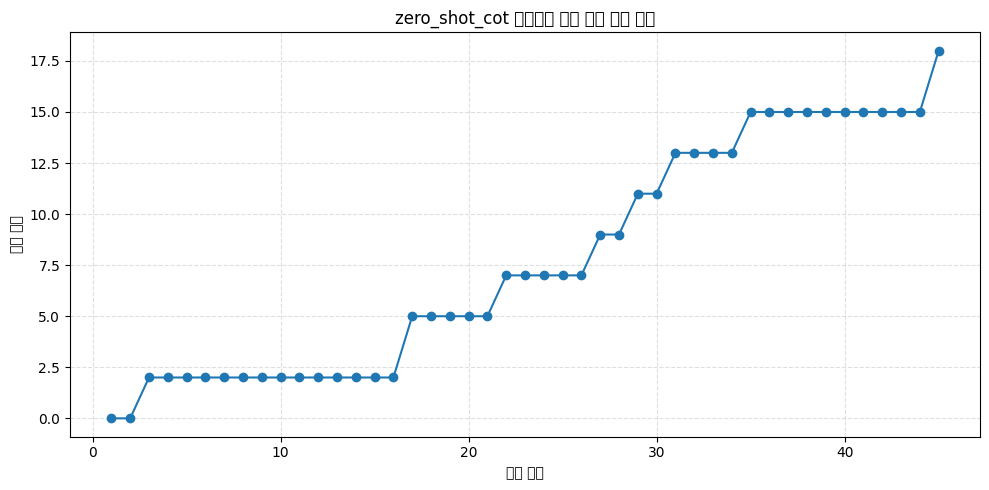

In [ ]:
import numpy as np

# 예시: 채점한 순서대로 누적 점수를 시뮬레이션
template = prompt_templates[0]  # 예: zero_shot_cot
cumulative_scores = []
score = 0

for idx, problem in enumerate(problem_list):
    result = predict(problem.to_json(), template)
    score += result
    cumulative_scores.append(score)

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_scores) + 1), cumulative_scores, marker='o')
plt.title(f'{template.name} 프롬프트 채점 누적 점수 변화')
plt.xlabel('문제 순번')
plt.ylabel('누적 점수')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
